In [1]:

import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
from pyspark.sql import SparkSession
spark= SparkSession.builder. \
appName("Major Project").\
master("local[1]").\
config("spark.memory.offHeap.enabled","true"). \
config("spark.memory.offHeap.size","10g").getOrCreate()
spark




# Regression 

In [3]:
df=spark.read.csv(r"C:/Users/abhi/Desktop/project feb2023/major project code/small dataset/train2.csv",inferSchema=True,header=True)

print('Number of rows: \t', df.count())
print('Number of columns: \t', len(df.columns))

#df.show(10)
df.columns

In [4]:
#dataype of input data 
df.printSchema()

root
 |-- bidirectional_duration_ms: integer (nullable = true)
 |-- bidirectional_packets: integer (nullable = true)
 |-- bidirectional_bytes: integer (nullable = true)
 |-- src2dst_first_seen_ms: long (nullable = true)
 |-- src2dst_last_seen_ms: long (nullable = true)
 |-- src2dst_packets: integer (nullable = true)
 |-- src2dst_bytes: integer (nullable = true)
 |-- dst2src_first_seen_ms: long (nullable = true)
 |-- dst2src_last_seen_ms: long (nullable = true)
 |-- dst2src_packets: integer (nullable = true)
 |-- dst2src_bytes: integer (nullable = true)
 |-- dst2src_duration_ms: integer (nullable = true)
 |-- src2dst_duration_ms: integer (nullable = true)
 |-- Target: integer (nullable = true)



In [5]:
df.groupBy('Target').count().show()

+------+-------+
|Target|  count|
+------+-------+
|     1|6637795|
|     0|    555|
+------+-------+



In [6]:
from pyspark.sql.types import *
for col in df.columns:
    df = df.withColumn(col, df[col].cast(IntegerType()))

In [7]:
import pyspark.sql.functions as f
from pyspark.sql.types import *

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import OneHotEncoder, StandardScaler, VectorAssembler, StringIndexer, Imputer

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:

pipe_stages= []

# create the un-standardized features vector
featureCols= ['bidirectional_duration_ms','bidirectional_packets','bidirectional_bytes',
              'src2dst_packets','src2dst_bytes','dst2src_packets','dst2src_bytes',
              'dst2src_duration_ms','src2dst_duration_ms']

assembler= VectorAssembler(inputCols= featureCols,
                           outputCol= "features",
                           handleInvalid="keep")
pipe_stages += [assembler]

# scale all features. 
ss= StandardScaler(inputCol="features",
                   outputCol="features_scale",
                   withMean= False,
                   withStd=True)
pipe_stages += [ss]

rf = RandomForestClassifier(labelCol="Target", featuresCol="features_scale", seed = 8464,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)
pipe_stages += [rf]

pipe= Pipeline(stages= pipe_stages)

In [9]:
mod = pipe.fit(df)

In [10]:
df2 = mod.transform(df)

In [11]:
mod.stages[-1].featureImportances
#df= pipe.fit(df).transform(df)

SparseVector(9, {0: 0.141, 1: 0.0399, 2: 0.1155, 3: 0.0389, 4: 0.2439, 5: 0.0691, 6: 0.2106, 7: 0.0425, 8: 0.0986})

In [12]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [13]:
 ExtractFeatureImp(mod.stages[-1].featureImportances, df2, "features").head(10)

,idx,name,score
4,4,src2dst_bytes,0.243852
6,6,dst2src_bytes,0.210589
0,0,bidirectional_duration_ms,0.140972
2,2,bidirectional_bytes,0.115505
8,8,src2dst_duration_ms,0.098607
5,5,dst2src_packets,0.069139
7,7,dst2src_duration_ms,0.042514
1,1,bidirectional_packets,0.039931
3,3,src2dst_packets,0.038890


In [14]:
varlist = ExtractFeatureImp(mod.stages[-1].featureImportances, df2, "features")

In [15]:
varidx = [x for x in varlist['idx'][0:4]]

C:\Users\abhi\AppData\Local\Temp\ipykernel_10832\2913626644.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  varidx = [x for x in varlist['idx'][0:4]]


In [16]:
varidx  

[4, 6, 0, 2]

In [43]:
pipe_stages1= []

# create the un-standardized features vector
featureCols1= ['src2dst_bytes',
              'dst2src_bytes',
              'bidirectional_duration_ms',
              'bidirectional_bytes',
              ]

assembler= VectorAssembler(inputCols= featureCols1,
                           outputCol= "features1",
                           handleInvalid="keep")
pipe_stages1 += [assembler]

# scale all features. 
ss= StandardScaler(inputCol="features1",
                   outputCol="features_scaled",
                   withMean= False,
                   withStd=True)
pipe_stages1 += [ss]




pipe2= Pipeline(stages= pipe_stages1)



In [44]:
mod2 = pipe2.fit(df)

In [45]:
df3 = mod2.transform(df)

In [52]:
df.columns

['bidirectional_duration_ms',
 'bidirectional_packets',
 'bidirectional_bytes',
 'src2dst_first_seen_ms',
 'src2dst_last_seen_ms',
 'src2dst_packets',
 'src2dst_bytes',
 'dst2src_first_seen_ms',
 'dst2src_last_seen_ms',
 'dst2src_packets',
 'dst2src_bytes',
 'dst2src_duration_ms',
 'src2dst_duration_ms',
 'Target']

In [53]:
df2.columns

['bidirectional_duration_ms',
 'bidirectional_packets',
 'bidirectional_bytes',
 'src2dst_first_seen_ms',
 'src2dst_last_seen_ms',
 'src2dst_packets',
 'src2dst_bytes',
 'dst2src_first_seen_ms',
 'dst2src_last_seen_ms',
 'dst2src_packets',
 'dst2src_bytes',
 'dst2src_duration_ms',
 'src2dst_duration_ms',
 'Target',
 'features',
 'features_scale',
 'rawPrediction',
 'probability',
 'prediction']

In [54]:
df3.columns

['bidirectional_duration_ms',
 'bidirectional_packets',
 'bidirectional_bytes',
 'src2dst_first_seen_ms',
 'src2dst_last_seen_ms',
 'src2dst_packets',
 'src2dst_bytes',
 'dst2src_first_seen_ms',
 'dst2src_last_seen_ms',
 'dst2src_packets',
 'dst2src_bytes',
 'dst2src_duration_ms',
 'src2dst_duration_ms',
 'Target',
 'features1',
 'features_scaled']

In [55]:
from pyspark.ml.classification import RandomForestClassifier

train_data, test_data = df3.randomSplit([0.7, 0.3])

In [57]:
from pyspark.ml.classification import RandomForestClassifier
import time

rf = RandomForestClassifier(labelCol="Target", featuresCol="features_scaled", seed = 8464,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

start = time.time()
rfModel = rf.fit(train_data)
end = time.time()
print("total time",end - start)

total time 364.4237654209137


In [64]:
start = time.time()

predictions = rfModel.transform(test_data)

end = time.time()
print("total time",end - start)

total time 0.10040736198425293


In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [66]:
# Build the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target", predictionCol="prediction", metricName="weightedFMeasure", metricLabel=1.0, beta = 2.0)

In [67]:
# Print out scores
print("F-2 score: ", evaluator.evaluate(predictions,  {evaluator.metricName: "weightedFMeasure"}), "\n")
print("Weighted Precision: ", evaluator.evaluate(predictions,  {evaluator.metricName: "weightedPrecision"}), "\n")
print("Weighted Recall: ", evaluator.evaluate(predictions,  {evaluator.metricName: "weightedRecall"}), "\n","\n","\n")


print("F-1 Score: ", evaluator.evaluate(predictions,  {evaluator.metricName: "f1"}), "\n")
print("Precision: ", evaluator.evaluate(predictions,  {evaluator.metricName: "precisionByLabel"}), "\n")
print("Recall: ",evaluator.evaluate(predictions,  {evaluator.metricName: "recallByLabel"}), "\n")

F-2 score:  0.9999170712246455 

Weighted Precision:  0.9999286837126932 

Weighted Recall:  0.9999286786258882 
 
 

F-1 Score:  0.9999025777452536 

Precision:  0.9999286776945014 

Recall:  1.0 



In [68]:
#Predict on training
prediction_train = rfModel.transform(train_data)

y_pred_train=prediction_train.select("prediction").collect()
y_orig_train=prediction_train.select("Target").collect()

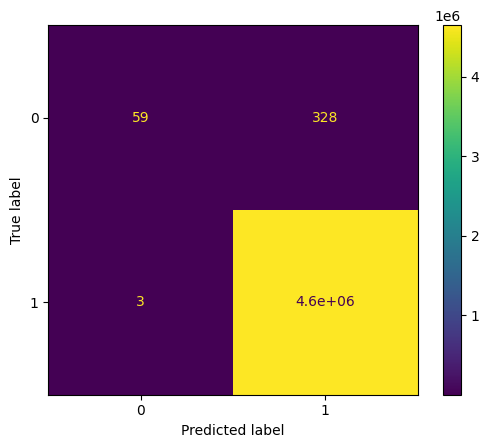

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#import matplotlib as plt

cm_train = confusion_matrix(y_orig_train, y_pred_train)

import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot()

plt.savefig('confusion_matrix_train.png')
plt.show()


In [74]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator(labelCol='Target')

# We have only two choices: area under ROC and PR curves :-(

auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.9575
Area under PR Curve: 1.0000


In [ ]:
 reference
    
    
    
#https://github.com/timlrx/timlrx.com/blob/master/data/blog/2018-06-19-
#feature-selection-using-feature-importance-score-creating-a-pyspark-estimator.md


#https://github.com/rampanyam/Predict-Next-Day-Rain-in-Australia-Classification
#-Problem/blob/main/Predicting_Rain_Tomorrow_Kaggle_Raghuram.ipynb


#https://haya-toumy.gitbook.io/spark-notes/pyspark/pyspark/random-forest-classifier-example
#Creating a Pipeline to Do All Feature Engineering